# Forecasting of Industrial Production of Electric and Gas Utilities

This file contains codes which builds a model that forecasts the industrial production of electric and gas utilities given monthly production units from January 1939 to September 2022. Statistical and Deep learning approaches are compared to identify the best performing approach for the model. To achieve this, the following tasks are performed:
1. Importing libraries and data file
2. Data profiling and time series formating
3. Handling missing values
4. Exploratory data analysis
5. Stationarity, autocorrelation and seasonality analysis
6. Forecasting using SARIMA
7. Forecasting using Prophet
8. Forecasting using LSTM
9. Forecasting using 1D CNN
10. Visualizing the model performance

## Importing Libraries and Data

In [555]:
import pandas as pd
import numpy as np
from pandas import read_csv
import time
from pandas import datetime
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from prophet import Prophet 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
df = read_csv('C:/Users/tomna/Desktop/Notebooks/Industrial Production of Electric and Gas Utilities/final_data.csv')
df.head()

,Observation_Date,Production_Index
0,01/01/1939,3.3335
1,01/02/1939,3.3590
2,01/03/1939,3.4353
3,01/04/1939,3.4607
4,01/05/1939,3.4607


In [556]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Observation_Date  1005 non-null   object 
 1   Production_Index  1005 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [557]:
# converting date column to standard date/time format
df['Observation_Date'] = pd.to_datetime(df['Observation_Date'], format='%d/%m/%Y')  # m for month, M for min
df_prophet = df.copy()    # copy the dataframe for prediction analysis using prophet in the later section
df = df.set_index('Observation_Date')
df = df.asfreq('MS', fill_value=np.nan)  # set the series frequency as month, starting at the first day of each month
df = df.sort_index()  # sort df by index in ascending order
df_DL = df.copy() # copy the dataframe for prediction analysis using deep learning approaches in the later sections
df

,Production_Index
Observation_Date,
1939-01-01,3.3335
1939-02-01,3.3590
1939-03-01,3.4353
1939-04-01,3.4607
1939-05-01,3.4607
...,...
2022-05-01,93.8455
2022-06-01,104.5226
2022-07-01,115.5735


In [558]:
# confirming the set index
pd.infer_freq(df.index)

'MS'

In [559]:
#verify that the series is complete, covering all dates in the range
missing_times = pd.date_range(df.index.min(), df.index.max(), freq=df.index.freq).difference(df.index).to_list()
if len(missing_times) == 0:
    print('The series is complete!')
else:
    print('The series is INCOMPLETE!! The following times are missing: ', missing_times)

The series is complete!


In [560]:
# check missing values for each column
df.isnull().sum()

Production_Index    0
dtype: int64

## Exploratory Data Analysis

### General Data Analysis

In [561]:
# extracting additional columns for analysis
df['Month'] = df.index.month
df['Year'] = df.index.year
df.head()

,Production_Index,Month,Year
Observation_Date,,,
1939-01-01,3.3335,1,1939
1939-02-01,3.3590,2,1939
1939-03-01,3.4353,3,1939
1939-04-01,3.4607,4,1939
1939-05-01,3.4607,5,1939


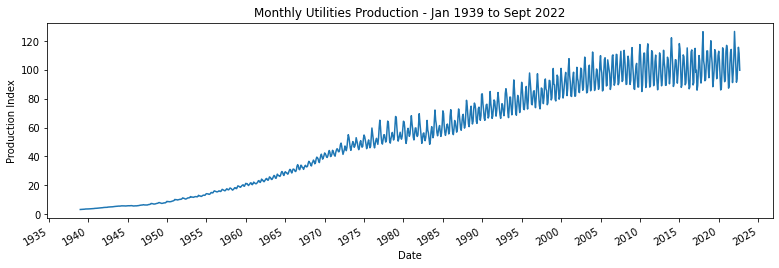

In [562]:
# plotting monthly production of the entire dataset
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df['Production_Index'])
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_title('Monthly Utilities Production - Jan 1939 to Sept 2022')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
# auto format font and rotation for date tick labels
plt.gcf().autofmt_xdate() 
plt.show()

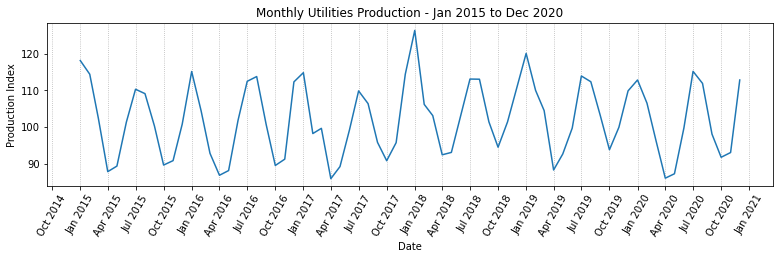

In [563]:
# Zooming a section of dataset
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(df.loc['2015-01-01':'2020-12-31', : ]['Production_Index']) # slicing data by index
ax.grid(axis='x', ls=':')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index") 
ax.set_title('Monthly Utilities Production - Jan 2015 to Dec 2020')
fig.suptitle('')
# set x-axis major ticks to monthly interval
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))  # from month 1 to 12 by the interval of 3
# format x-tick labels as day number and 3-letter month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params('x', labelrotation=60)
plt.show()

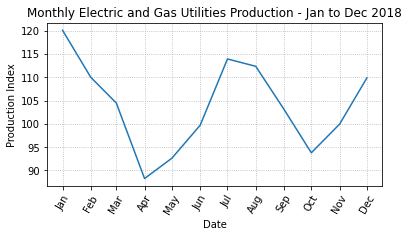

In [564]:
# Zooming a section of data
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(df.loc['2019-01-01':'2019-12-31', : ]['Production_Index']) # slicing data by index
ax.grid(True, ls=':')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index") 
ax.set_title('Monthly Electric and Gas Utilities Production - Jan to Dec 2018')
fig.suptitle('')
# set x-axis major ticks to monthly interval
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# format x-tick labels as day number and 3-letter month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.tick_params('x', labelrotation=60)
plt.show()

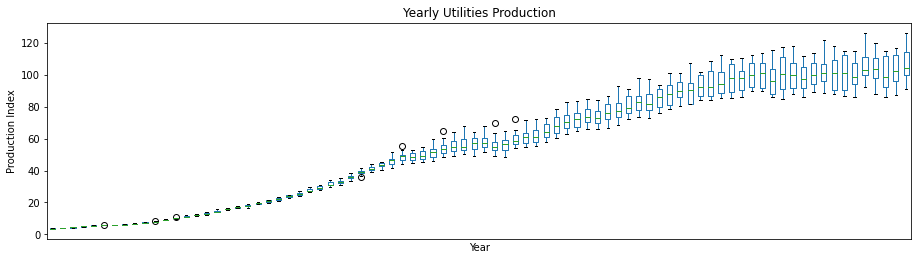

In [565]:
# plotting the production by year
fig, ax = plt.subplots(figsize=(15,4))
df.boxplot(column='Production_Index', by='Year', ax=ax)
#df.plot.bar(y='Energy_Output', x='Year', ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Production Index") 
ax.set_title('Yearly Utilities Production')
fig.suptitle('')
ax.grid(False)
# set yearly locators
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
#plt.gcf().autofmt_xdate() 
ax.tick_params('x', labelrotation=80)
#plt.setp(ax.xaxis.get_label(), visible=True)
#plt.setp(ax.get_xticklabels(), visible=True)
plt.show()

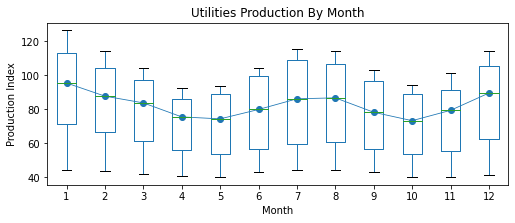

In [566]:
# plotting the production by month
df['1970-08-1':'2022-09-01'].boxplot(column='Production_Index', by='Month', grid=False)
df['1970-08-1':'2022-09-01'].groupby('Month')['Production_Index'].median().plot(style='o-', linewidth=0.8)
plt.xlabel('Month')
plt.ylabel('Production Index')
plt.title("Utilities Production By Month")
plt.suptitle("")
plt.gcf().set_size_inches(8,3)
plt.show()

The general observation is that the production has been continuously increasing from 1939 to 2022. This is likely due to the increase in the population thus the number of consumers. Winter and summer months are observed to yield peak production for obvious reasons, that is, a high demand of energy to home consumers to warm and cool their homes during winter and summer periods respectively. This trend appears to repetitive in each year.

### Stationarity, Autocorrelation and Seasonality Analysis

#### Stationarity

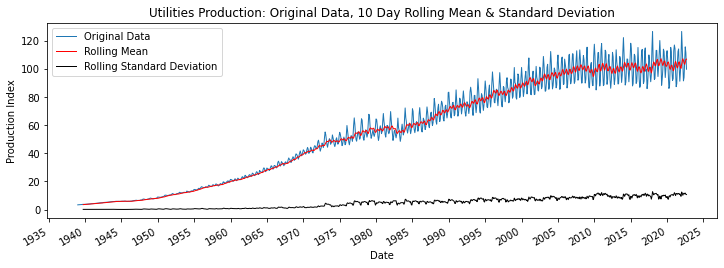

In [567]:
# plotting original data, and rooling mean and standard deviation
lags = 10
rolling_mean_day = df['Production_Index'].rolling(lags).mean()
rolling_std_day = df['Production_Index'].rolling(lags).std()
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df['Production_Index'], label="Original Data", linewidth=1.0)
ax.plot(rolling_mean_day, color="red", label="Rolling Mean", linewidth=1.0)
ax.plot(rolling_std_day, color="black", label = "Rolling Standard Deviation", linewidth=1.0)
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_title('Utilities Production: Original Data, 10 Day Rolling Mean & Standard Deviation')
fig.suptitle('')
# set yearly locators
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.legend(loc='best')
# auto format font and rotation for date tick labels
plt.gcf().autofmt_xdate() 
plt.show()

The mean production of each 10 month period is observed to be increasing drastically. The standard deviation of data in the same time window appears to be increasing slightly from 1973. This indicates that the time series is not stationary.

#### Autocorrelation

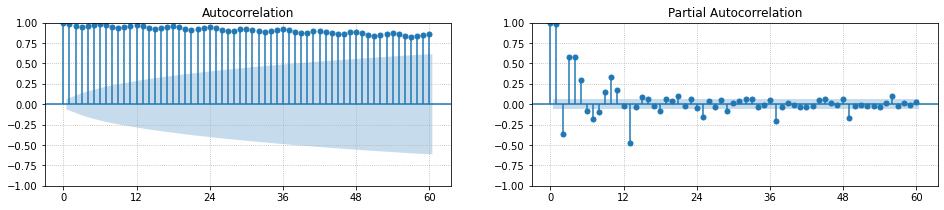

In [568]:
# Autocorrelation and partial autocorrelation plots
fig, axes = plt.subplots(1,2, figsize=(16,3),constrained_layout=True)
lags = 60
plot_acf(df['Production_Index'], ax=axes[0], lags=lags)
axes[0].set_title('Autocorrelation')
axes[0].grid(True, ls=':')
axes[0].set_xticks(np.arange(0, lags + 1, 12))  # specify xticks from 0 to the lag range by a difference of 12 months so as to observe seasonality 
plot_pacf(df['Production_Index'], ax=axes[1], lags=lags)
axes[1].set_title('Partial Autocorrelation')
axes[1].grid(True, ls=':')
axes[1].set_xticks(np.arange(0, lags + 1, 12))
plt.subplots_adjust(wspace=0.2)
plt.show()

The autocorrelation plot shows that the last lag has a significant correlation with each of the previous 60 lags with a 95% confidence interval.  We can also see a seasonality being depicted by the plot by repetitive peaks and dips of correlation values at constant lag intervals. The partial autocorrelation plot, on the other hand, shows correlations for a small number of lags following the removal of correlations of intervening observations. Both plots suggest that there is a strong dependence between lags thus previous time series values can be used to predict the future ones.

#### Seasonality

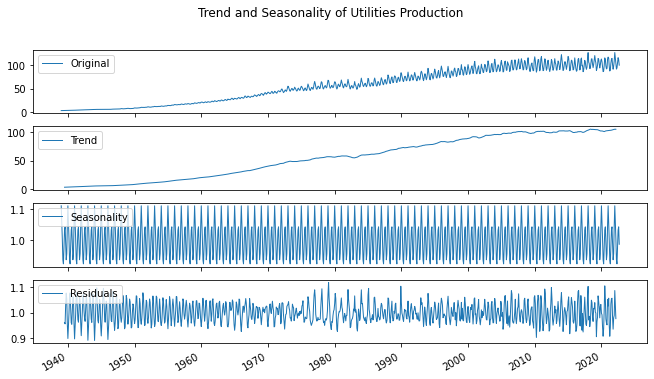

In [569]:
# plotting time series decompose plots of the entire dataset to observe trend and seasonality
df_decompose = df['Production_Index']
ts_decomposition = seasonal_decompose(df_decompose, model='multiplicative')  # addictive for linear trends and multiplicative for non-linear trends
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid
# Plotting the time series and it's components together
fig, axes = plt.subplots(4, 1, figsize=(11,6), sharex=True, sharey=False)
# First plot to the Original time series
axes[0].plot(df_decompose, label='Original', linewidth=1.0) 
axes[0].legend(loc='upper left')
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend', linewidth=1.0)
axes[1].legend(loc='upper left')
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality', linewidth=1.0)
axes[2].legend(loc='upper left')
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals', linewidth=1.0)
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
axes[3].legend(loc='upper left')
plt.gcf().autofmt_xdate() 
fig.suptitle('Trend and Seasonality of Utilities Production')
plt.show()

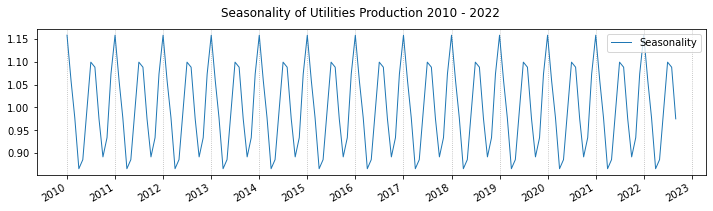

In [570]:
# plotting time series decompose plots of section of the dataset
df_decompose = df['Production_Index']['2010':'2022']
ts_decomposition = seasonal_decompose(df_decompose, model='multiplicative')  # addictive for linear trends and multiplicative for non-linear trends
seasonal_estimate = ts_decomposition.seasonal
# plotting seasonality component
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(seasonal_estimate, label='Seasonality', linewidth=1.0)
ax.grid(axis='x', ls=':')   # plotting vertical grids
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.legend(loc='upper right')
plt.gcf().autofmt_xdate() 
fig.suptitle('Seasonality of Utilities Production 2010 - 2022')
plt.show()

The decompose analysis has depicted the upward trend of the time series and its 12 month seasonality. This indicates that the time series is not stationary. This is confirmed by the ADF test below which has failed to reject our null hypothesis that the series is stationary. 

In [571]:

df['Production_Index'] = df['Production_Index'].astype('float32')  # convert the data to float32 from float64 to reduce the data size thus prevent memory limitation error
adft = adfuller(df['Production_Index'], autolag="AIC")
adft_df = pd.DataFrame({"Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"], 
                          "Values":[adft[0], adft[1], adft[2], adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]})
print('ADF Test Results:')
print(round(adft_df, 5))  
#print(round(adft_df.style.hide_index(), 5))   # style.hide_index() hides any form of index such as 0,1,2.....
print('\nConclusion:')
if (adft[1] < 0.05) or (adft[0] < adft[4]["5%"]):
    print (">> Reject the null hypothesis - Time series is stationary")
else:
    print (">> Failed to reject the null hypothesis - Time series is non-stationary")

ADF Test Results:
                        Metric     Values
0              Test Statistics   -0.67259
1                      p-value    0.85372
2             No. of lags used   22.00000
3  Number of observations used  982.00000
4          critical value (1%)   -3.43703
5          critical value (5%)   -2.86449
6         critical value (10%)   -2.56834

Conclusion:
>> Failed to reject the null hypothesis - Time series is non-stationary


## Forecasting Utilities Production
### Statistical Methods
#### SARIMA

In [572]:
# modelling a series with seasonality 
sarima_model = auto_arima(df['Production_Index'],
                 start_p=0,  # initial guess for AR(p)
                 start_d=0,  # initial guess for I(d)
                 start_q=0,  # initial guess for MA(q)
                 max_p=4,    # max guess for AR(p)
                 max_d=4,    # max guess for I(d)
                 max_q=4,    # max guess for MA(q)
                 seasonal=True,
                 m=12,       # we have yearly seasonality for monthly observations, therefore 12 observations per each season
                 start_P=0,  # initial guess for seasonal AR(P)
                 start_D=0,  # initial guess for seasonal I(D)
                 start_Q=0,  # initial guess for seasonal MA(Q)
                 max_P=3, 
                 max_D=2, 
                 max_Q=3,
                 trend='c',
                 information_criterion='aic',
                 trace=True,
                 error_action='ignore',
                 suppress_warnings=True, 
                 stepwise=True  # runs random seach instead of grid search
                 )
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6325.745, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5486.506, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6325.745, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6047.971, Time=0.27 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4226.677, Time=1.48 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4515.698, Time=0.71 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=4223.651, Time=4.62 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=4413.274, Time=1.83 sec
 ARIMA(0,1,1)(3,0,1)[12] intercept   : AIC=4184.455, Time=15.86 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=4282.107, Time=10.65 sec
 ARIMA(0,1,1)(3,0,2)[12] intercept   : AIC=inf, Time=18.36 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=4295.793, Time=9.38 sec
 ARIMA(1,1,1)(3,0,1)[12] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1005
Model:             SARIMAX(2, 1, 1)x(3, 0, 1, 12)   Log Likelihood               -2028.315
Date:                            Thu, 17 Nov 2022   AIC                           4074.630
Time:                                    22:11:32   BIC                           4118.835
Sample:                                01-01-1939   HQIC                          4091.428
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.103      0.918      -0.002       0.003
ar.L1          0.5172      0.023     22.332      0.000       0.472       0.563
ar.L2         -0.0263      0.023     -1.130      0.259      -0.072       0.019
ma.L1         -0.9400      0.011    -82.717      0.000      -0.962      -0.918
ar.S.L12       0.9945      0.033     30.147      0.000       0.930       1.059
ar.S.L24      -0.2206      0.030     -7.333      0.000      -0.280      -0.162
ar.S.L36       0.2201      0.025      8.863      0.000       0.171       0.269
ma.S.L12      -0.6464      0.035    -18.362      0.000      -0.715      -0.577
sigma2         3.1633      0.089     35.588      0.000       2.989       3.338
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               651.72
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              94.30   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [573]:
# splitting the dataset into train and test data
df_train = df.loc['1990-01-01':'2018-12-31']
df_test = df.loc['2019-01-01':'2022-09-01']
print('Train dataset size: ', len(df_train))
print('Test dataset size: ', len(df_test))

Train dataset size:  348
Test dataset size:  45


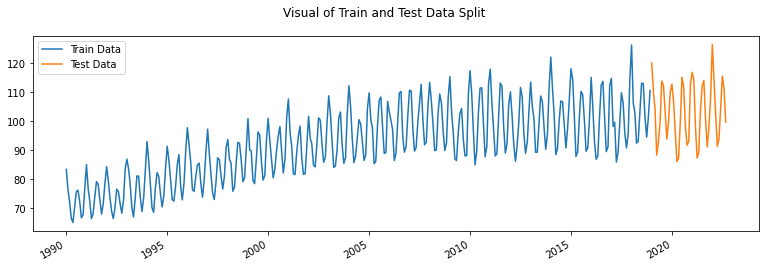

In [582]:
# visualizing train and test datasets
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df_train['Production_Index'], label='Train Data')
ax.plot(df_test['Production_Index'], label='Test Data')
#ax.axvline('2018-12-31', color='black', linestyle='--', linewidth=0.6)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
fig.suptitle('Visual of Train and Test Data Split')
plt.show()

In [575]:
# make predictions
sarima_model.fit(df_train['Production_Index'])
forecast_sarima = sarima_model.predict(n_periods=len(df_test['Production_Index']))
# convert the predictions to dataframe
df_forecast_sarima = pd.DataFrame(forecast_sarima, index = df_test.index, columns=['Predictions'])

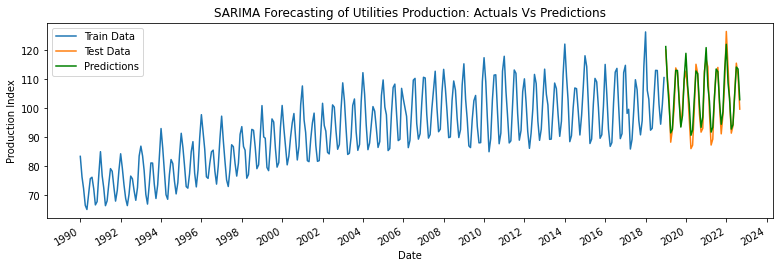

In [583]:
# visualizing actuals and predictions
fig, ax = plt.subplots(figsize=(13,4))
#ax.plot(df['Energy_Output'].loc['1995-01-01':'2022-09-01'], label='Actuals')  # reduce the period of original data for image clarity
ax.plot(df_train['Production_Index'].loc['1990-01-01':'2018-12-31'], label='Train Data')  # reduce the period of training data for image clarity
ax.plot(df_test['Production_Index'], label='Test Data')
ax.plot(df_forecast_sarima, color='green', label='Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_title('SARIMA Forecasting of Utilities Production: Actuals Vs Predictions')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.legend(loc='best')
plt.gcf().autofmt_xdate() # auto format font and rotation for date tick labels
plt.show()

In [577]:
# generating the model's performance measures
MAPE = round(mean_absolute_percentage_error(df_test['Production_Index'].values, df_forecast_sarima.values), 4)
MAE = round(mean_absolute_error(df_test['Production_Index'].values, df_forecast_sarima.values), 3)
RMSE = round(np.sqrt(mean_squared_error(df_test['Production_Index'].values, df_forecast_sarima.values)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  2.44 % |  MAE:  2.479  |  RMSE:  3.079


The model has a MAPE of 2.44% meaning that the accuracy in forecasting the 45 periods is 97.56%

In [578]:
# We now forecast energy output for the next 3 years using the model
# first, we combine former train and test datasets to make a new train dataset
new_df_train = pd.concat([df_train, df_test], axis=0)   # appending the second dataframe on the the first one
# make predictions
prediction_time = 36  # 36 months of future time
sarima_model.fit(new_df_train['Production_Index'])
forecast_sarima = sarima_model.predict(n_periods=prediction_time)  
# convert the predictions to dataframe
df_new_forecast = pd.DataFrame(forecast_sarima, index = pd.date_range(start='2022-10-01', periods=prediction_time, freq='MS'), columns=['Predictions'])
df_new_forecast

,Predictions
2022-10-01,93.390304
2022-11-01,101.071296
2022-12-01,110.863208
2023-01-01,119.324197
2023-02-01,110.059034
2023-03-01,100.048475
2023-04-01,90.918416
2023-05-01,92.976783
2023-06-01,103.367569
2023-07-01,114.533124


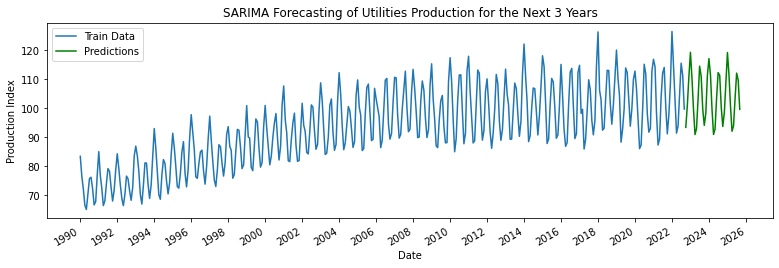

In [579]:
# visualizing actuals and predictions
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(new_df_train['Production_Index'], label='Train Data')  # reduce the period of training data for image clarity
ax.plot(df_new_forecast, color='green', label='Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
#ax.set_xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2025-09-01'))
ax.set_title('SARIMA Forecasting of Utilities Production for the Next 3 Years')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.show()

#### Prophet

In [585]:
# renaming date and energy output columns as per prophet's requirement
df = df_prophet
df = df.rename(columns={'Observation_Date':'ds','Production_Index':'y'}) # converting the two columns to the required names by prophet
df.sort_values(by='ds', inplace=True)
df.head()

,ds,y
0,1939-01-01,3.3335
1,1939-02-01,3.3590
2,1939-03-01,3.4353
3,1939-04-01,3.4607
4,1939-05-01,3.4607


In [586]:
# partitioning training and testing data
df_train = df.loc[df['ds'].dt.year <= 2018]   # partitioning using date objects. Train data 1939 - 2019
df_test = df.loc[df['ds'].dt.year > 2018]    # Test data 2020 - 2022
# defining the model and fitting the data
model_prt = Prophet(
    changepoint_prior_scale=0.5, # default is 0.05
    growth='linear', 
    yearly_seasonality=True, 
    seasonality_mode='multiplicative' # the magnitude of seasonality grows with time as per observed series. Default is 'addictive' meaning the magnitude is constant
    )
model_prt.fit(df_train)
# make predictions
future_periods = model_prt.make_future_dataframe(periods=len(df_test), freq='MS')
df_forecast_prt = model_prt.predict(future_periods)  # this returns predictions of an entire dataset onstead of testing dataset only!!
df_forecast_prt[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # yhat_lower and yhat_upper are prediction confidence/intervals

23:04:51 - cmdstanpy - INFO - Chain [1] start processing
23:04:52 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,1939-01-01,3.857185,1.292277,6.496486
1,1939-02-01,3.630488,0.709725,6.520951
2,1939-03-01,3.438483,0.736187,6.269593
3,1939-04-01,3.105718,0.238387,5.737754
4,1939-05-01,3.116296,0.322968,5.902667
...,...,...,...,...
1000,2022-05-01,94.084959,90.981275,97.186755
1001,2022-06-01,102.963190,99.829322,106.065258
1002,2022-07-01,111.653338,108.468682,115.065739
1003,2022-08-01,112.453456,109.342027,115.615186


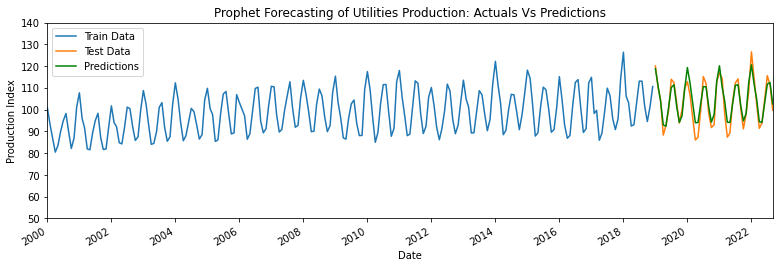

In [587]:
# set 'ds' as index for simplifying plotting
df_train = df_train.set_index('ds')
df_test = df_test.set_index('ds')
df_forecast_prt = df_forecast_prt.set_index('ds')
# plot train and test data against predictions
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df_train['y'], label='Train Data')
ax.plot(df_test['y'], label='Test Data')
ax.plot(df_forecast_prt['yhat'].loc['2019-01-01':'2022-09-01'], color='green', label='Predictions') # limiting the forecasted values to have the same index range as testing data
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2022-09-01')) # limiting index period for visual clarity
ax.set_ylim(bottom=50, top =140)
ax.set_title('Prophet Forecasting of Utilities Production: Actuals Vs Predictions')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
plt.show()

In [588]:
# generating the model's performance measures
MAPE = round(mean_absolute_percentage_error(df_test['y'].values, df_forecast_prt['yhat'].loc['2019-01-01':'2022-09-01'].values), 3)
MAE = round(mean_absolute_error(df_test['y'].values, df_forecast_prt['yhat'].loc['2019-01-01':'2022-09-01'].values), 3)
RMSE = round(np.sqrt(mean_squared_error(df_test['y'].values, df_forecast_prt['yhat'].loc['2019-01-01':'2022-09-01'].values)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  3.0 % |  MAE:  2.994  |  RMSE:  3.67


### Machine Learning (Deep Learning) Methods
#### LSTM

In [487]:
# get the original dataframe with dates as index
df = df_DL
df

,Production_Index
Observation_Date,
1939-01-01,3.3335
1939-02-01,3.3590
1939-03-01,3.4353
1939-04-01,3.4607
1939-05-01,3.4607
...,...
2022-05-01,93.8455
2022-06-01,104.5226
2022-07-01,115.5735


In [488]:
# converting the dataframe into a supervised series as per LSTM input shape format requirements
# first we define the function which converts df into a series of a historical data (X) defined by a window size (time steps) for predicting the next value (y) as per below example
    # [[[1], [2], [3], [4], [5]]] [6]
    # [[[2], [3], [4], [5], [6]]] [7]
    # [[[3], [4], [5], [6], [7]]] [8]
def create_supervised_series(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
np.random.seed(7) # set the random seed to ensure that our sample data in the train and test dataset will be the same every time we use the same seed number

In [489]:
# normalize the dataset to a range 0 - 1
print('Shape before scaling: ', df.shape)
print('Min Max: ', df['Production_Index'].min(), ', ', df['Production_Index'].max())
df_as_np = df.values.astype('float32')  # ensure all values are in float, values returned as numpy array
scaler = MinMaxScaler(feature_range=(0, 1))
df_as_np = scaler.fit_transform(df_as_np)  # data is returned as numpy array
print('Shape after scaling: ', df_as_np.shape)
print('Min Max: ', df_as_np.min().round(5), ', ', df_as_np.max().round(5))

Shape before scaling:  (1005, 1)
Min Max:  3.3335 ,  126.5273
Shape after scaling:  (1005, 1)
Min Max:  0.0 ,  1.0


In [490]:
# splitting data into train and test datasets
train_size = int(len(df_as_np) * 0.8)  # assign 80% of data for training. The number should an integer to work in the next statement
df_train = df_as_np[0:train_size, :] # slicing numpy array - without iloc
df_test = df_as_np[train_size:len(df)+1, :]
print('Train & Test data size: ', len(df_train), ', ', len(df_test))
# reshape data into X=t and y=t+1
look_back = 1
X_train, y_train = create_supervised_series(df_train, look_back)
X_test, y_test = create_supervised_series(df_test, look_back)
print('Train data shapes: ', X_train.shape, y_train.shape)
print('Test data shapes: ', X_test.shape, y_test.shape)

Train & Test data size:  804 ,  201
Train data shapes:  (802, 1) (802,)
Test data shapes:  (199, 1) (199,)


In [491]:
#reshape the input to be [samples, time steps, features]
# HERE we use a window based time series method. This approach uses previous lags (lookback) as unique input features processed at one time (timesteps=1)
timesteps = 1
X_train = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[1])) # features=look_back. This method uses previous lags as different input features
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[1]))
print('X_train and X_test new shapes: ', X_train.shape, ', ', X_test.shape)

X_train and X_test new shapes:  (802, 1, 1) ,  (199, 1, 1)


In [492]:
# fit our data to the optimal LSTM network determined after tuning (performed in a separate file)
model = Sequential()
model.add(LSTM(416, activation='tanh', kernel_initializer='uniform', input_shape=(timesteps, look_back), return_sequences=True))
model.add(Dropout(0.1))
# hidden unit 1
model.add(LSTM(960, kernel_initializer='lecun_uniform', activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
# hidden unit 2
model.add(LSTM(256, kernel_initializer='glorot_normal', activation='tanh', return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))  
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer) 
stop_early = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]  # set early stopping to prevent overfitting
model.fit(X_train, y_train, epochs=200, batch_size=15, validation_split=0.1, callbacks=stop_early, verbose=0)
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 416)            695552    
                                                                 
 dropout_219 (Dropout)       (None, 1, 416)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 960)            5287680   
                                                                 
 dropout_220 (Dropout)       (None, 1, 960)            0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               1246208   
                                                                 
 dropout_221 (Dropout)       (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 1)               

In [493]:
# make prediction on train data
y_train_pred = model.predict(X_train, verbose=0)
# make prediction on test data
y_test_pred = model.predict(X_test, verbose=0)
# inverse actual data and predictions to their original scales
y_train = np.reshape(y_train, (y_train.shape[0], 1))  # changing the shape of the data to resamble with the predicted ones i.e from (1, y_train.shape[0]) to (y_train.shape[0], 1)
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred)
print()
print('X_train and X_test new shapes: ', X_train.shape, ', ', X_test.shape)
print('Train actuals and predictions shapes: ', y_train.shape, ', ', y_train_pred.shape)
print('Test actuals and predictions shapes: ', y_test.shape, ', ', y_test_pred.shape)


X_train and X_test new shapes:  (802, 1, 1) ,  (199, 1, 1)
Train actuals and predictions shapes:  (802, 1) ,  (802, 1)
Test actuals and predictions shapes:  (199, 1) ,  (199, 1)


In [494]:
# assessing model's performance in predicting test data
MAPE = round(mean_absolute_percentage_error(y_test, y_test_pred), 4)
MAE = round(mean_absolute_error(y_test, y_test_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  8.129999786615372 % |  MAE:  8.376  |  RMSE:  9.888


In [495]:
# converting the train actuals and predictions to dataframe. The values have no index, therefore index should be assigned (the requirement in DataFrame function) based on the index of the original series
# we first convert the values from 2 dimensions to 1 dimensions (to remain with shape[0]) as required by dataframe function
y_train = y_train.flatten()
y_train_pred = y_train_pred.flatten()
df_train_results = pd.DataFrame({'Train Actuals':y_train, 'Train Predictions':y_train_pred}, index=df_DL.index[0:len(y_train)])
y_test = y_test.flatten()
y_test_pred = y_test_pred.flatten()
df_test_results = pd.DataFrame({'Test Actuals':y_test, 'Test Predictions':y_test_pred}, index=df_DL.index[len(y_train):len(y_train)+len(y_test)]) 

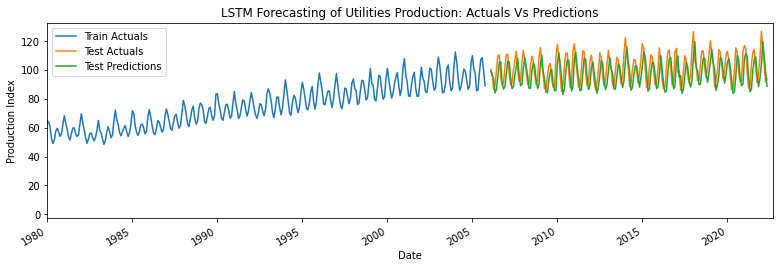

In [496]:
# plotting model's prediction on the test data
# we first shift train and test data result to match its index with that of original data
df_train_results = df_train_results.shift(look_back)
df_test_results = df_test_results.shift(look_back*2 + 1)
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df_train_results['Train Actuals'], label='Train Actuals')
ax.plot(df_test_results['Test Actuals'], label='Test Actuals')  # reduce the period of training data for image clarity
ax.plot(df_test_results['Test Predictions'], label='Test Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_xlim(pd.to_datetime('1980-01-01'), pd.to_datetime('2022-09-01'))
#ax.set_ylim(bottom=20, top =130)
ax.set_title('LSTM Forecasting of Utilities Production: Actuals Vs Predictions')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
# auto format font and rotation for date tick labels
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
plt.show()

#### 1D CNN

In [525]:
# we use the same df_train and df_test we obtained in the previous section (LSTM)
print('Train & Test data size: ', len(df_train), ', ', len(df_test))
# reshape into X=t and y=t+1
look_back = 10
X_train, y_train = create_supervised_series(df_train, look_back)
X_test, y_test = create_supervised_series(df_test, look_back)
#reshape the input to be [samples, time steps, features]
# HERE we use a window based time series method. This approach uses previous lags (lookback) as unique input features processed at one time (timesteps=1)
timesteps = 1
X_train = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[1])) # features=look_back. This method uses previous lags as different input features
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[1]))
print('Train data shapes: ', X_train.shape, y_train.shape)
print('Test data shapes: ', X_test.shape, y_test.shape)

Train & Test data size:  804 ,  201
Train data shapes:  (793, 1, 10) (793,)
Test data shapes:  (190, 1, 10) (190,)


In [526]:
# creating the optimal 1D CNN network after tuning (performed in a separate file)
model = Sequential()
model.add(Conv1D(filters=384, kernel_size=2, strides=1, padding='same', activation='tanh', kernel_initializer='glorot_normal',
        input_shape=(timesteps, look_back))) 
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))  
model.add(Dropout(0.1))
# hidden layer 1
model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='lecun_uniform'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))  
model.add(Dropout(0.4))
# hidden layer 2
model.add(Conv1D(filters=160, kernel_size=3, strides=1, padding='same', activation='tanh', kernel_initializer='glorot_uniform'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))  
model.add(Dropout(0.1))
# hidden layer 3
model.add(Conv1D(filters=224, kernel_size=3, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))  
model.add(Dropout(0.5))
# hidden layer 4
model.add(Conv1D(filters=352, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))  
model.add(Dropout(0.1)) 
# hidden layer 5
model.add(Conv1D(filters=96, kernel_size=2, strides=1, padding='same', activation='sigmoid', kernel_initializer='normal'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))  
model.add(Dropout(0.1)) 
model.add(Flatten())
model.add(Dense(1))  
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer) 
stop_early = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]  # set early stopping to prevent overfitting
model.fit(X_train, y_train, epochs=200, batch_size=15, validation_split=0.1, callbacks=stop_early, verbose=0)
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_240 (Conv1D)         (None, 1, 384)            8064      
                                                                 
 max_pooling1d_240 (MaxPooli  (None, 1, 384)           0         
 ng1D)                                                           
                                                                 
 dropout_246 (Dropout)       (None, 1, 384)            0         
                                                                 
 conv1d_241 (Conv1D)         (None, 1, 256)            196864    
                                                                 
 max_pooling1d_241 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_247 (Dropout)       (None, 1, 256)          

In [527]:
# make prediction
y_test_pred = model.predict(X_test, verbose=0)
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

In [528]:
# assessing model's performance in predicting test data
MAPE = round(mean_absolute_percentage_error(y_test, y_test_pred), 4)
MAE = round(mean_absolute_error(y_test, y_test_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  9.570000320672989 % |  MAE:  10.327  |  RMSE:  12.935


In [529]:
# converting the train actuals and predictions to dataframe. The values have no index, therefore index should be assigned (the requirement in DataFrame function) based on the index of the original series
# we first convert the values from 2 dimensions to 1 dimensions (to remain with shape[0]) as required by dataframe function
# y_train = y_train.flatten()
# y_train_pred = y_train_pred.flatten()
# df_train_results = pd.DataFrame({'Train Actuals':y_train, 'Train Predictions':y_train_pred}, index=df_DL.index[0:len(y_train)])
y_test = y_test.flatten()
y_test_pred = y_test_pred.flatten()
df_test_results = pd.DataFrame({'Test Actuals':y_test, 'Test Predictions':y_test_pred}, index=df_DL.index[len(y_train):len(y_train)+len(y_test)]) 

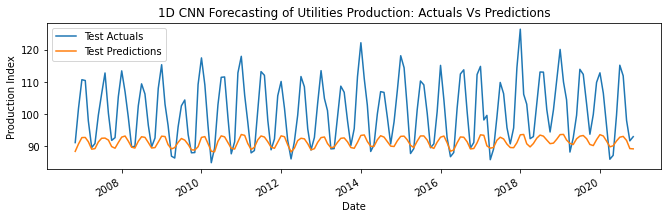

In [530]:
# plotting model's prediction on the test data
# we first shift the test data result to match its index with that of original data
df_test_results = df_test_results.shift(look_back*2 + 1)
fig, ax = plt.subplots(figsize=(11,3))
ax.plot(df_test_results['Test Actuals'], label='Test Actuals')  # reduce the period of training data for image clarity
ax.plot(df_test_results['Test Predictions'], label='Test Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
#ax.set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2022-09-01'))
#ax.set_ylim(bottom=80, top =140)
ax.set_title('1D CNN Forecasting of Utilities Production: Actuals Vs Predictions')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
# auto format font and rotation for date tick labels
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
plt.show()

Based on the visuals of predictions of the models and their performance measures, we clearly see that SARIMA has performed better for this problem than the other methods.